# Quick Tutorial
This is a short, straightforward tutorial for generating your first waveform with `bhpwave`.

First from the `bhpwave` package and its `waveform` module, load the waveform generator `KerrWaveform`

In [1]:
from bhpwave.waveform import KerrWaveform, KerrFrequencyWaveform
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bhpwave.trajectory.inspiral import TrajectoryData

Next define a set of paramters for evaluating your waveform

In [17]:
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses
a = 0.9 # dimensionless spin of the primary
p0 = 6.55 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc
Phi_phi0 = 0.2 # initial azimuthal position of the secondary
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years

injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

Then load an instance of the waveform generator class

In [18]:
kerr_gen_td = KerrWaveform()

And generate a signal!

In [19]:
h = kerr_gen_td(*injection_paramters)

We can inspect our signal by plotting the signal over the entire observation

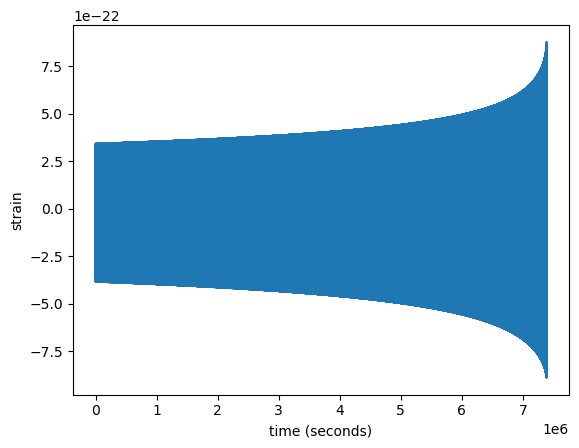

In [20]:
t = np.arange(h.shape[0])*dt
plt.plot(t, h.real)
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.show()

Or by looking at the behavior of the different polarizations over a short time segment

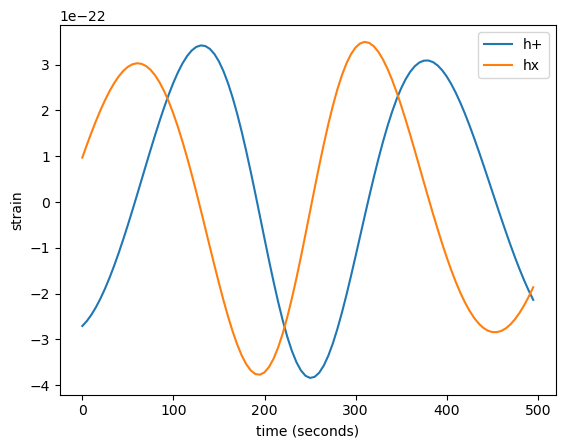

In [21]:
plt.plot(t[:100], h.real[:100], label="h+")
plt.plot(t[:100], -h.imag[:100], label="hx")
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.legend()
plt.show()

We can also generate waveforms in the frequency domain using the `KerrFrequencyWaveform` generator

In [22]:
kerr_gen_fd = KerrFrequencyWaveform()

Giving the same time step `dt` and signal duration `T` will generate signal that approximates the discrete Fourier transform of the time-domain signal generated by the `KerrWaveform` generator

In [23]:
hf = kerr_gen_fd(*injection_paramters)

Therefore we can compare it to the DFT of the time-domain signal

In [24]:
hdft = np.fft.rfft([h.real, -h.imag])*dt
freq = np.fft.rfftfreq(h.shape[0], d=dt)

Note that we can also give the frequency-domain generator a specific frequency grid on which to evaluate the waveform.

In [25]:
hf2 = kerr_gen_fd(*injection_paramters, frequencies=freq)

In the above example, this should generate the same signal as `hf`, which we can confirm using `np.allclose()`

In [26]:
np.allclose(hf, hf2, atol=0, rtol=1e-10)

True

Finally we can compare the DFT and frequency-domain waveforms to qualitatively observe the agreement, particularly at the peak of the frequency spectrum

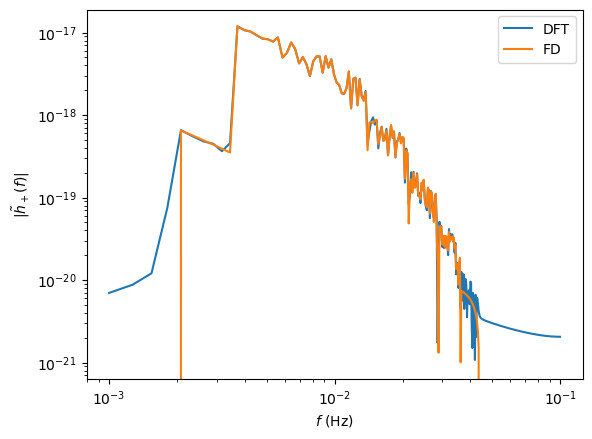

In [27]:
plt.loglog(freq[freq > 1e-3][::2000], np.abs(hdft[0])[freq > 1e-3][::2000], label = 'DFT')
plt.loglog(freq[freq > 1e-3][::2000], np.abs(hf[0])[freq > 1e-3][::2000], label = 'FD')
plt.ylabel("$|\\tilde{h}_+(f)|$")
plt.xlabel("$f$ (Hz)")
plt.legend()
plt.show()

## Accessing amplitude and phase data

The waveform generators can also output the amplitudes and phases of the time- and frequency-domain $(l, m)$-modes. This is accessible through the `harmonics_data()` method in our waveform generator classes

In [28]:
lm_modes = [(2,2), (3,3), (4,4)]
Aflms, Phiflms = kerr_gen_fd.harmonics_data(*injection_paramters, select_modes=lm_modes, frequencies=freq)

The function returns the amplitudes and phases of $\tilde{h}_{lm}(f) = \tilde{A}_{lm}(f) e^{i \Phi_{lm}(f)}$ and $\tilde{h}_{l-m}(-f) = \tilde{A}_{l-m}(-f) e^{i \Phi_{l-m}(-f)}$. Note that the amplitudes $\tilde{A}_{lm}(f)$ are scaled by the spin-weighted spherical harmonics $Y_{-2lm}$. Therefore, they are not strictly positive if $Y_{-2lm}$ is not positive.

To visualize these modes, let's plot the amplitudes as a function of frequency for the different modes.

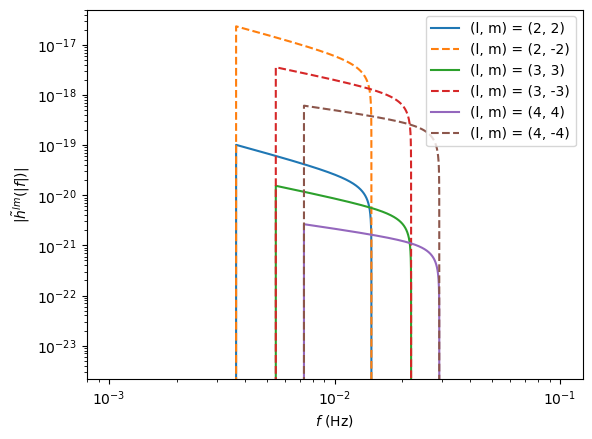

In [29]:
for i in range(len(lm_modes)):
    plt.loglog(freq[freq > 1e-3], np.abs(Aflms[2*i][freq > 1e-3]), label = f"(l, m) = ({lm_modes[i][0]}, {lm_modes[i][1]})")
    plt.loglog(freq[freq > 1e-3], np.abs(Aflms[2*i+1][freq > 1e-3]), '--', label = f"(l, m) = ({lm_modes[i][0]}, -{lm_modes[i][1]})")
plt.ylabel("$|\\tilde{h}^{lm}(|f|)|$")
plt.xlabel("$f$ (Hz)")
plt.legend(loc = 'upper right')
plt.show()

We can then construct Fourier transforms of the plus and cross polarizations of the gravitational wave strain from the amplitudes and phases using the relations
$$ \tilde{h}^{l,m>0}_+(f) = \frac{1}{2}\left[\tilde{h}_{lm}(f)\right] $$
$$ \tilde{h}^{l,m<0}_+(f) = \frac{1}{2}\left[\tilde{h}^*_{l-m}(-f)\right] $$
$$ \tilde{h}^{l,m>0}_\times(f) = \frac{i}{2}\left[\tilde{h}_{lm}(f)\right] $$
$$ \tilde{h}^{l,m<0}_\times(f) = -\frac{i}{2}\left[\tilde{h}^*_{l-m}(-f)\right] $$

In [30]:
lm_modes = [(2,2)]
Aflms, Phiflms = kerr_gen_td.harmonics_data(*injection_paramters, select_modes=lm_modes)